In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
from src.serialization_lib import *
from src.data_types import *
from IPython.display import HTML, display

import pandas as pd
import statistics
import datetime
import numpy as np
# pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = "{:,.2f}".format

In [3]:
INITIAL_PORTFOLIO_VALUE = 10000
# PORTFOLIO_SIZE = 30
# REBALANCE_DAYS = 90
PORTFOLIO_SIZE = 10
REBALANCE_DAYS = 365

BASE_METRIC = EvaluationMetric.EV_EBIT
TEST_METRIC = EvaluationMetric.P_B
STOCKS_UNIVERSE = StockUniverse.LARGE
PORTFOLIO_WEIGHT_STRATEGY = StockBasketWeightApproach.EQUAL_WEIGHTING

In [4]:
def plot_backtest(
    df: pd.DataFrame,
    base_metric: EvaluationMetric,
    test_metric: EvaluationMetric, 
    rebalance_days: int,
    portfolio_size: int,
    stocks_universe: StockUniverse
):
    df_to_plot = df[['base_price', 'test_price']]
    df_to_plot.plot(title=(
        f'{str(base_metric)} (base)'
        f' VS {str(test_metric)} (test)\n'
        f' Rebalance freq: {rebalance_days} days\n'
        f' Portfolio size: {portfolio_size} stocks\n'
        f' Universe of stocks: {str(stocks_universe)}'))

In [5]:
filename = df_feather_filename('df_debug', BASE_METRIC, TEST_METRIC, REBALANCE_DAYS, PORTFOLIO_SIZE, STOCKS_UNIVERSE)
df_debug = read_df_debug_from_feather(filename)

filename = df_feather_filename('df_res', BASE_METRIC, TEST_METRIC, REBALANCE_DAYS, PORTFOLIO_SIZE, STOCKS_UNIVERSE)
df_res = read_df_res_from_feather(filename)

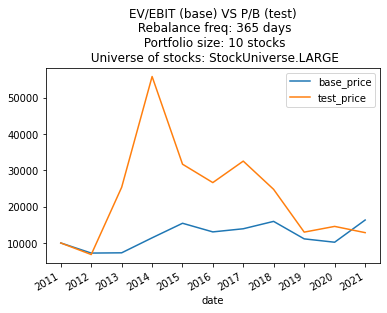

In [6]:
plot_backtest(df_res, BASE_METRIC, TEST_METRIC, REBALANCE_DAYS, PORTFOLIO_SIZE, STOCKS_UNIVERSE)

In [94]:
df_debug.iloc[0:3]

,prev_date,curr_date,base_portfolio_prev_price,base_portfolio_curr_price,base_portfolio_tickers_closed,base_portfolio_per_ticker_data,new_base_portfolio_per_ticker_data,per_stock_up,portfolio_change
date,,,,,,,,,
2011-04-01,2011-01-03,2011-04-01,"10,000.00","9,043.29",{},"[[ADGI, 3.3, 3.52], [AXGN, 4.0, 2.84], [BDSI, 3.55, 3.55], [BOPH, 1.79, 1.7], [CBFV, 12.056, 12....","[[ABAT, NA, 2.07], [ADGI, NA, 3.52], [ATV, NA, 17.662], [BOPH, NA, 1.7], [CAGM, NA, 0.66], [CBEH...",36.67%,-9.57%
2011-07-01,2011-04-01,2011-07-01,"9,043.29","7,401.58",{},"[[ABAT, 2.07, 1.07], [ADGI, 3.52, 3.5], [ATV, 17.662, 19.914], [BOPH, 1.7, 0.91], [CAGM, 0.66, 0...","[[ADGI, NA, 3.5], [BOPH, NA, 0.91], [BSPM, NA, 24.15], [CAGM, NA, 0.6], [CETC, NA, 47.8], [CMFB,...",33.33%,-18.15%
2011-09-30,2011-07-01,2011-09-30,"7,401.58","6,244.36",{ADGI},"[[ADGI, 3.5, 3.15], [BOPH, 0.91, 0.8], [BSPM, 24.15, 14.28], [CAGM, 0.6, 0.22], [CETC, 47.8, 31....","[[ABAT, NA, 1.01], [ASYS, NA, 8.0], [BERK, NA, 6.39], [BLRX, NA, 43.35], [BOPH, NA, 0.8], [BSET,...",20.0%,-15.63%


In [93]:
df_res.iloc[0:3]

,base_price,test_price,base_price_prev,test_price_prev
date,,,,
2011-01-03,"10,000.00","10,000.00",NaN,NaN
2011-04-01,"9,043.29","10,288.22","10,000.00","10,000.00"
2011-07-01,"7,401.58","8,456.43","9,043.29","10,288.22"


In [78]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
def color_per_cell(v):
    per = float(v if str(v)[-1] != '%' else str(v)[:-1])
    if per < -25:
        return "background-color: orangered"
    elif per >= -25 and per < 0:
        return "background-color: #ffcccb"
    elif per >= 0 and per < 25:
        return "background-color: #90ee90"
    elif per >= 25:
        return "background-color: green"

def display_two_decimal_places(val):
    return f'${val:,.2f}'

def display_date_only(d):
    return d.strftime('%Y-%m-%d')

def tuple_array_to_df(tuple_arr):
    df = pd.DataFrame.from_records(tuple_arr, columns=['ticker', 'prev', 'curr'])
    df['ticker'] = df['ticker'].str.replace("'", "")
    return df

def per_stocks_up(tupple_arr):
    return f'{round(100 * sum([1 for (ticker, prev, curr) in tupple_arr if (curr > prev)]) / len(tupple_arr), 2)}%'

def p_change(r):
    return f'{round(100 * (r.base_portfolio_curr_price - r.base_portfolio_prev_price ) / r.base_portfolio_prev_price, 2)}%'

def p_change2(r):
    return f'{round(100 * (r.curr - r.prev ) / r.prev, 2)}%'

def get_date_based_df(df_debug, date):
    df_date = df_debug.loc[date]
    tuple_arr = df_date['base_portfolio_per_ticker_data']
    df = tuple_array_to_df(tuple_arr)
    tickers_closed = [str(s) for s in df_date['base_portfolio_tickers_closed']]
    df['up'] = df.apply(lambda r: r['curr'] > r['prev'], axis=1)
    df['per_change'] = df.apply(lambda r: p_change2(r), axis=1)
    df['did_close'] = df.apply(lambda r: "Closed" if str(r.ticker) in tickers_closed else "", axis=1)
    df = df.sort_values(by='per_change', key=lambda col: col.map(lambda v: float(v[:-1])))    
    summary_row = [
        'Summary / Total ',
        round(sum(df['prev']), 20),
        round(sum(df['curr']), 20),
        f"{round(100 * sum(df['up']) / len(df['up']))}%",
        f"{round(statistics.mean([float(p[:-1]) for p in df['per_change']]), 2)}%",
        ""
    ]
    df.loc[len(df.index)] = summary_row
    return df

df_debug['per_stock_up'] = df_debug.apply(lambda r: per_stocks_up(list(r.base_portfolio_per_ticker_data)), axis=1)
df_debug['portfolio_change'] = df_debug.apply(lambda r: p_change(r), axis=1)

df_debug_readable = df_debug.copy()
df_debug_readable['num_tickers_closed'] = df_debug_readable.apply(lambda r: len(r.base_portfolio_tickers_closed), axis=1)
df_debug_readable = df_debug.drop(['base_portfolio_tickers_closed', 'base_portfolio_per_ticker_data', 'new_base_portfolio_per_ticker_data'], axis=1)
df_debug_readable.rename(columns={'base_portfolio_prev_price': 'prev', 'base_portfolio_curr_price': 'curr'}, inplace=True)

date_to_inspect = df_debug.index[7]
df_date = get_date_based_df(df_debug, date_to_inspect)

In [79]:
df_debug_with_style = df_debug_readable.round(2).style \
    .format({
        'curr': display_two_decimal_places,
        'prev': display_two_decimal_places,
        'date': display_date_only,
        'prev_date': display_date_only,
        'curr_date': display_date_only,    
    })

df_debug_with_style.applymap(color_per_cell, subset=['per_stock_up', 'portfolio_change'])

,prev_date,curr_date,prev,curr,per_stock_up,portfolio_change
date,,,,,,
2011-04-01 00:00:00,2011-01-03,2011-04-01,"$10,000.00","$9,043.29",36.67%,-9.57%
2011-07-01 00:00:00,2011-04-01,2011-07-01,"$9,043.29","$7,401.58",33.33%,-18.15%
2011-09-30 00:00:00,2011-07-01,2011-09-30,"$7,401.58","$6,244.36",20.0%,-15.63%
2011-12-29 00:00:00,2011-09-30,2011-12-29,"$6,244.36","$5,987.10",46.67%,-4.12%
2012-03-28 00:00:00,2011-12-29,2012-03-28,"$5,987.10","$6,782.75",80.0%,13.29%
2012-06-26 00:00:00,2012-03-28,2012-06-26,"$6,782.75","$5,691.74",33.33%,-16.09%
2012-09-24 00:00:00,2012-06-26,2012-09-24,"$5,691.74","$6,079.12",60.0%,6.81%
2012-12-21 00:00:00,2012-09-24,2012-12-21,"$6,079.12","$5,657.01",33.33%,-6.94%
2013-03-22 00:00:00,2012-12-21,2013-03-22,"$5,657.01","$6,681.71",70.0%,18.11%


In [80]:
df_with_style = df_date.style \
    .format({
        'curr': display_two_decimal_places,
        'prev': display_two_decimal_places,
    }) \
    .set_caption(f"Rebalance results on {datetime.datetime.strftime(date_to_inspect, '%Y-%m-%d')} for {str(STOCKS_UNIVERSE)}") \
    .set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'black'),
            ('font-size', '16px'),
            ('text-align', 'center'),        
        ]
}])

df_with_style.applymap(color_per_cell, subset=['per_change'])

,ticker,prev,curr,up,per_change,did_close
15,LGHS,$1.09,$0.26,False,-76.15%,
7,CPHI,$0.37,$0.20,False,-45.95%,
1,BOPH,$0.85,$0.48,False,-43.53%,
8,CRTP,$0.70,$0.40,False,-42.86%,
4,CHBT,$2.90,$1.69,False,-41.72%,
27,VRNM,$3.45,$2.20,False,-36.23%,
18,MSN,$1.29,$1.06,False,-17.5%,
9,CVVT,$0.52,$0.43,False,-17.47%,
6,CMKG,$1.15,$0.97,False,-15.65%,
29,XUE,$2.58,$2.24,False,-13.07%,


In [91]:
def cagr(start, end, n):
    cagr = pow(end / start, 1 / n) - 1
    return cagr * 100

def value_growth(cagr, n):
    return 10000 * pow(1 + cagr / 100, n)    

def display_data(data, caption):
    df = pd.DataFrame(data, columns = ['Time Period', 'CAGR', 'SD', '$10,000 grows to...'])
    df = df.style.set_caption(caption)\
        .format({"CAGR": "{:.2f}%", "SD": "{:.2f}%", '$10,000 grows to...': "${:,.2f}"}) \
        .set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'black'),
                ('font-size', '16px'),
                ('text-align', 'center'),        
            ]
        }])
    display(df.applymap(color_per_cell, subset=['CAGR', 'SD']))

min_date = min(df_res.index)
max_date = max(df_res.index)

time_period_days = 365 * 1 # 1 year(s)

tabulated_base_data = []
tabulated_test_data = []

period_start_date = min_date

idx_s = 0
idx_e = 0

for date, data in df_res.iterrows():
    idx_e += 1
    td = (date - period_start_date)
    if (td.days >= time_period_days - 10):
        n = round(td.days / 365)    
        df = df_res.iloc[idx_s:idx_e]
        
        prev_data = df_res.iloc[idx_s]
        curr_data = df_res.iloc[idx_e]
        
        period_start_dateiod = list(d.strftime('%Y-%m-%d') for d in [period_start_date, date])
        
        base_start_p = prev_data['base_price']
        base_end_p = curr_data['base_price']
        base_cagr = cagr(base_end_p, base_start_p, n)
        base_sd = np.std(df['base_price'].values)
        base_sd = base_sd / np.sum(df['base_price'].values) * 100
        base_growth = value_growth(base_cagr, n)
        
        tabulated_base_data.append([period_start_dateiod, base_cagr, base_sd, base_growth])
        
        test_start_p = prev_data['test_price']
        test_end_p = curr_data['test_price']
        test_cagr = cagr(test_start_p, test_end_p, n)
        test_sd = np.std(df['test_price'].values)
        test_sd = test_sd / np.sum(df['test_price'].values) * 100
        test_growth = value_growth(test_cagr, n)

        tabulated_test_data.append([period_start_dateiod, test_cagr, test_sd, test_growth])
        
        idx_s = idx_e + 1
        period_start_date = date
        

display_data(tabulated_base_data, f"{BASE_METRIC}")
display_data(tabulated_test_data, f"{TEST_METRIC}")

,Time Period,CAGR,SD,"$10,000 grows to..."
0,"['2011-01-03', '2011-12-29']",47.43%,4.04%,"$14,743.28"
1,"['2011-12-29', '2012-12-21']",-14.82%,1.10%,"$8,518.39"
2,"['2012-12-21', '2013-12-18']",-24.31%,1.95%,"$7,569.29"
3,"['2013-12-18', '2014-12-12']",-1.82%,1.20%,"$9,818.07"
4,"['2014-12-12', '2015-12-08']",-0.51%,0.30%,"$9,948.56"
5,"['2015-12-08', '2016-12-02']",-19.02%,0.83%,"$8,097.63"
6,"['2016-12-02', '2017-11-27']",-24.17%,2.46%,"$7,582.62"
7,"['2017-11-27', '2018-11-21']",4.30%,1.28%,"$10,430.48"
8,"['2018-11-21', '2019-11-15']",9.82%,2.91%,"$10,981.94"
9,"['2019-11-15', '2020-11-10']",-51.51%,4.29%,"$4,849.10"


,Time Period,CAGR,SD,"$10,000 grows to..."
0,"['2011-01-03', '2011-12-29']",30.44%,4.35%,"$13,043.65"
1,"['2011-12-29', '2012-12-21']",-2.84%,3.20%,"$9,716.37"
2,"['2012-12-21', '2013-12-18']",58.61%,4.13%,"$15,860.81"
3,"['2013-12-18', '2014-12-12']",-28.39%,4.71%,"$7,161.38"
4,"['2014-12-12', '2015-12-08']",-43.08%,7.15%,"$5,691.70"
5,"['2015-12-08', '2016-12-02']",2.68%,1.32%,"$10,267.71"
6,"['2016-12-02', '2017-11-27']",-5.04%,1.24%,"$9,495.89"
7,"['2017-11-27', '2018-11-21']",-32.28%,4.62%,"$6,772.27"
8,"['2018-11-21', '2019-11-15']",-17.56%,5.17%,"$8,244.11"
9,"['2019-11-15', '2020-11-10']",364.64%,8.76%,"$46,463.53"
